# Introduction to Convolutional Neural Networks

## 1. Convolutions

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)

## 2. Convolutional layers and Pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a CNN. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks ([Keras included](https://keras.io/layers/convolutional/)) will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/pool.png)

## 3. Convolutional Neural Network (CNN) architecture

Now that we got all the building blocks, let's see what a typical convolutional neural network might look like!

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/cnn.png)

A typical CNN architecture for a $k$-class image classification can be split into two distinct parts---a chain of repeating $\mathrm{Conv}\rightarrow\mathrm{Pool}$ layers (sometimes with more than one convolutional layer at once), followed by a few fully connected layers (taking each pixel of the computed images as an independent input), culminating in a $k$-way softmax layer, to which a cross-entropy loss is optimised. I did not draw the activation functions here to make the sketch clearer, but do keep in mind that typically after every convolutional or fully connected layer, an activation (e.g. ReLU) will be applied to all of the outputs.

Note the effect of a single $\mathrm{Conv}\rightarrow\mathrm{Pool}$ pass through the image: it reduces height and width of the individual channels in favour of their number, i.e. *depth*.

The softmax layer and cross-entropy loss are both introduced in more detail [in the previous tutorial](http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits). For summarisation purposes, a softmax layer's purpose is converting any vector of real numbers into a vector of *probabilities* (nonnegative real values that add up to 1). Within this context, the probabilities correspond to the likelihoods that an input image is a member of a particular class. Minimising the cross-entropy loss has the effect of maximising the model's confidence in the *correct* class, without being concerned for the probabilites for other classes---this makes it a more suitable choice for probabilistic tasks compared to, for example, the squared error loss.

## 4. Detour: Overfitting, regularisation and dropout

This will be the first (and hopefully the only) time when I will divert your attention to a seemingly unrelated topic. It regards a very important pitfall of machine learning---**overfitting** a model to the training data. While this is primarily going to be a major topic of the next tutorial in the series, the negative effects of overfitting will tend to become quite noticeable on the networks like the one we are about to build, and we need to introduce a way to properly protect ourselves against it, before going any further. Luckily, there is a very simple technique we can use.

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a sine curve, with white additive noise applied to the data points: 

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/plotsin.png)

Here we have a training set (denoted by blue circles) derived from the original sine wave, along with some noise. If we fit a degree-3 polynomial to this data, we get a fairly good approximation to the original curve. Someone might argue that a degree-14 polynomial would do better; indeed, given we have 15 points, such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters, we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method I will introduce here is **dropout**---a technique that initially might seem like "dark magic", but actually helps to eliminate exactly the failure modes described above. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers. An illustration is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/drop.png)

## 5. Let's implement a simple CNN!!

### Check library versions

In [ ]:
# Make sure we have the necessary version of libraries installed
import sys
import torch
print('Your python version: {}'.format(sys.version_info.major))
print('Your pytorch version: {}'.format(torch.__version__))
print('GPU being used: {}'.format(torch.cuda.get_device_name(0)))

Your python version: 3
Your pytorch version: 1.12.1+cu113
GPU being used: Tesla T4


### Import Libraries

In [ ]:
# Load liraries
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

### Download data and split

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

## split trainset into train and vaidation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



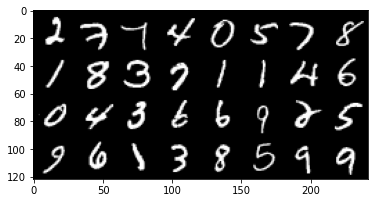

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
def getValidationStats(criterion, valloader):
  val_loss, val_acc = 0.0, 0.0
  for j, (images, labels) in enumerate(valloader, 0):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      val_loss += criterion(outputs, labels).detach().item()
      val_acc += get_accuracy(outputs, labels, BATCH_SIZE)
  return val_loss/j, val_acc/j

In [ ]:
history = []
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    val_running_loss = 0.0
    val_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    val_stats = getValidationStats(criterion, valloader)
    val_running_loss += val_stats[0]
    val_acc += val_stats[1]

    model.eval()
    print('Epoch: %d | Loss: %.4f | Validation loss: %.4f | Train Accuracy: %.2f | Validation Accuracy: %.2f' \
          %(epoch, train_running_loss / i, val_running_loss, train_acc/i, val_acc))
    history.append([epoch, train_running_loss/i, val_running_loss, train_acc/i, val_acc])

Epoch: 0 | Loss: 1.6422 | Validation loss: 1.5970 | Train Accuracy: 82.23 | Validation Accuracy: 87.26
Epoch: 1 | Loss: 1.5134 | Validation loss: 1.4977 | Train Accuracy: 95.16 | Validation Accuracy: 97.19
Epoch: 2 | Loss: 1.4857 | Validation loss: 1.4919 | Train Accuracy: 97.82 | Validation Accuracy: 97.69
Epoch: 3 | Loss: 1.4799 | Validation loss: 1.4891 | Train Accuracy: 98.38 | Validation Accuracy: 97.96
Epoch: 4 | Loss: 1.4761 | Validation loss: 1.4862 | Train Accuracy: 98.71 | Validation Accuracy: 98.22


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.14


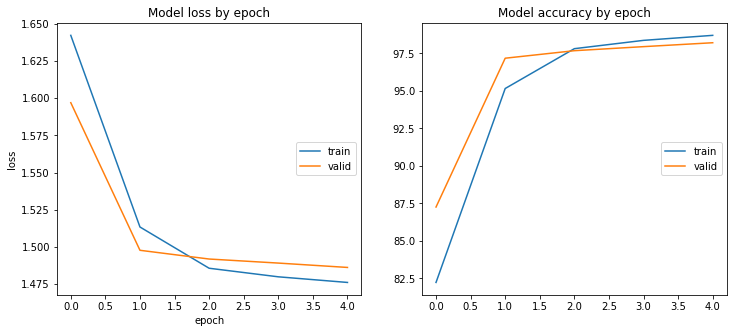

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))

history = np.array(history)
axis[0].plot(history[:, 1])
axis[0].plot(history[:, 2])
axis[1].plot(history[:, 3])
axis[1].plot(history[:, 4])

axis[0].set_title('Model loss by epoch')
axis[1].set_title('Model accuracy by epoch')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['train', 'valid'], loc='right')
axis[1].legend(['train', 'valid'], loc='right')
plt.show()

**CLASS ASSIGNMENT:**

**Test on your own examples: 1/ draw yourself by hand (for example in Microsoft Paint or equivalent image editor, or on paper that you photograph afterwards with your smartphone) a few examples for each class of handwritten digits; 2/ rescale and crop your images so that their size is 28x28 pixels with nearly no white borders around digits, and make sure they are saved as grayscale or even black-and-white; 3/ In the code cell below, load your images, plot them, and then feed each one into your best trained ConvNet and display for each one the class probabilities estimated by your ConvNet:**

**Optional assignment: in code cell below, by applying a good combination and parameterization of regularization techniques, + increasing the number of training epochs, + reducing the proportion of validation hold-out, TRY TO OBTAIN >99% acuracy ON TEST SET:**

# Introduction to Autoencoders

## What is an autoencoder?

An autoencoder is a type of artificial neural network used to learn data encodings in an unsupervised manner.

The aim of an autoencoder is to learn a lower-dimensional representation (encoding) for a higher-dimensional data, typically for dimensionality reduction, by training the network to capture the most important parts of the input image.

![link text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

## The architecture of autoencoders
Let’s start with a quick overview of autoencoders’ architecture.

Autoencoders consist of 3 parts:

1. Encoder: A module that compresses the train-validate-test set input data into an encoded representation that is typically several orders of magnitude smaller than the input data.

2. Bottleneck: A module that contains the compressed knowledge representations and is therefore the most important part of the network.

3. Decoder: A module that helps the network“decompress” the knowledge representations and reconstructs the data back from its encoded form. The output is then compared with a ground truth.

The architecture as a whole looks something like this:

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60ba3ecb0057e25cf8317ede_autoencoder1.png)

## The relationship between the Encoder, Bottleneck, and Decoder

### **Encoder**

The encoder is a set of convolutional blocks followed by pooling modules that compress the input to the model into a compact section called the bottleneck.

### **Bottleneck**

The most important part of the neural network, and ironically the smallest one, is the bottleneck. The bottleneck exists to restrict the flow of information to the decoder from the encoder, thus, allowing only the most vital information to pass through.

Since the bottleneck is designed in such a way that the maximum information possessed by an image is captured in it, we can say that the bottleneck helps us form a knowledge-representation of the input.

Thus, the encoder-decoder structure helps us extract the most from an image in the form of data and establish useful correlations between various inputs within the network.

A bottleneck as a compressed representation of the input further prevents the neural network from memorising the input and overfitting on the data.

As a rule of thumb, remember this: The smaller the bottleneck, the lower the risk of overfitting.

However, very small bottlenecks would restrict the amount of information storable, which increases the chances of important information slipping out through the pooling layers of the encoder.

### **Decoder**

Finally, the decoder is a set of upsampling and convolutional blocks that reconstructs the bottleneck's output.

Since the input to the decoder is a compressed knowledge representation, the decoder serves as a “decompressor” and builds back the image from its latent attributes.

## 5 types of autoencoders

Here are five popular autoencoders that we will discuss:

1. Undercomplete autoencoders
2. Sparse autoencoders
3. Contractive autoencoders
4. Denoising autoencoders
5. Variational Autoencoders (for generative modelling)

### **Undercomplete Autoencoders**

An undercomplete autoencoder is one of the simplest types of autoencoders.

The way it works is very straightforward — Undercomplete autoencoder takes in an image and tries to predict the same image as output, thus reconstructing the image from the compressed bottleneck region.

Undercomplete autoencoders are truly unsupervised as they do not take any form of label, the target being the same as the input.

The primary use of autoencoders like such is the generation of the latent space or the bottleneck, which forms a compressed substitute of the input data and can be easily decompressed back with the help of the network when needed.

This form of compression in the data can be modeled as a form of dimensionality reduction.



### **Sparse Autoencoders**

Sparse autoencoders are similar to the undercomplete autoencoders in that they use the same image as input and ground truth. However the means via which encoding of information is regulated is significantly different.

While undercomplete autoencoders are regulated and fine-tuned by regulating the size of the bottleneck, the sparse autoencoder is regulated by changing the number of nodes at each hidden layer.

Since it is not possible to design a neural network that has a flexible number of nodes at its hidden layers, sparse autoencoders work by penalizing the activation of some neurons in hidden layers.

In other words, the loss function has a term that calculates the number of neurons that have been activated and provides a penalty that is directly proportional to that.

This penalty, called the sparsity function, prevents the neural network from activating more neurons and serves as a regularizer.

There are two primary ways in which the sparsity regularizer term can be incorporated into the loss function.

1. L1 Loss: In here, we add the magnitude of the sparsity regularizer as we do for general regularizers:

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60ba8036928ca12ef7d76bd1_loss%20function.PNG)

2. KL-Divergence: In this case, we consider the activations over a collection of samples at once rather than summing them as in the L1 Loss method. We constrain the average activation of each neuron over this collection.

Considering the ideal distribution as a Bernoulli distribution, we include KL divergence within the loss to reduce the difference between the current distribution of the activations and the ideal (Bernoulli) distribution:


![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60ba80767501ca3ff79c5214_bern.PNG)

### **Contractive Autoencoders**

Similar to other autoencoders, contractive autoencoders perform task of learning a representation of the image while passing it through a bottleneck and reconstructing it in the decoder.

The contractive autoencoder also has a regularization term to prevent the network from learning the identity function and mapping input into the output.

Contractive autoencoders work on the basis that similar inputs should have similar encodings and a similar latent space representation. It means that the latent space should not vary by a huge amount for minor variations in the input.

### **Denoising Autoencoders**

Denoising autoencoders, as the name suggests, are autoencoders that remove noise from an image.

As opposed to autoencoders we’ve already covered, this is the first of its kind that does not have the input image as its ground truth.

In denoising autoencoders, we feed a noisy version of the image, where noise has been added via digital alterations. The noisy image is fed to the encoder-decoder architecture, and the output is compared with the ground truth image.

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60bbe71203425680a535a476_pasted%20image%200.png)

The denoising autoencoder gets rid of noise by learning a representation of the input where the noise can be filtered out easily.

While removing noise directly from the image seems difficult, the autoencoder performs this by mapping the input data into a lower-dimensional manifold (like in undercomplete autoencoders), where filtering of noise becomes much easier.

Essentially, denoising autoencoders work with the help of non-linear dimensionality reduction. The loss function generally used in these types of networks is L2 or L1 loss.

### **Variational Autoencoders**

Standard and variational autoencoders learn to represent the input just in a compressed form called the latent space or the bottleneck.

Therefore, the latent space formed after training the model is not necessarily continuous and, in effect, might not be easy to interpolate.

For example—

This is what a variational autoencoder would learn from the input:

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60bbe752a4dbfa4ee8b4912e_funny1.png)

# Come on, let's do a bit of coding now!

In [ ]:
# Import libraries
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [ ]:
latent_dims = 10
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 396171


In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.127500
Epoch [2 / 50] average reconstruction error: 0.073698
Epoch [3 / 50] average reconstruction error: 0.066182
Epoch [4 / 50] average reconstruction error: 0.062035
Epoch [5 / 50] average reconstruction error: 0.059278
Epoch [6 / 50] average reconstruction error: 0.057313
Epoch [7 / 50] average reconstruction error: 0.055778
Epoch [8 / 50] average reconstruction error: 0.054578
Epoch [9 / 50] average reconstruction error: 0.053674
Epoch [10 / 50] average reconstruction error: 0.052841
Epoch [11 / 50] average reconstruction error: 0.052220
Epoch [12 / 50] average reconstruction error: 0.051633
Epoch [13 / 50] average reconstruction error: 0.051088
Epoch [14 / 50] average reconstruction error: 0.050693
Epoch [15 / 50] average reconstruction error: 0.050248
Epoch [16 / 50] average reconstruction error: 0.050002
Epoch [17 / 50] average reconstruction error: 0.049676
Epoch [18 / 50] average reconstruction error: 0.049378
Epoch 

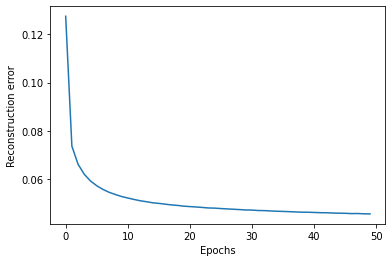

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.047048


Original images


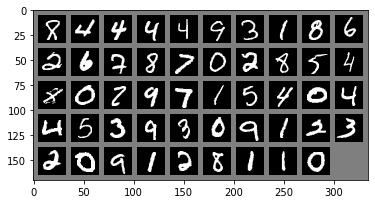

Autoencoder reconstruction:


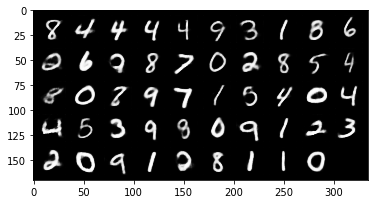

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

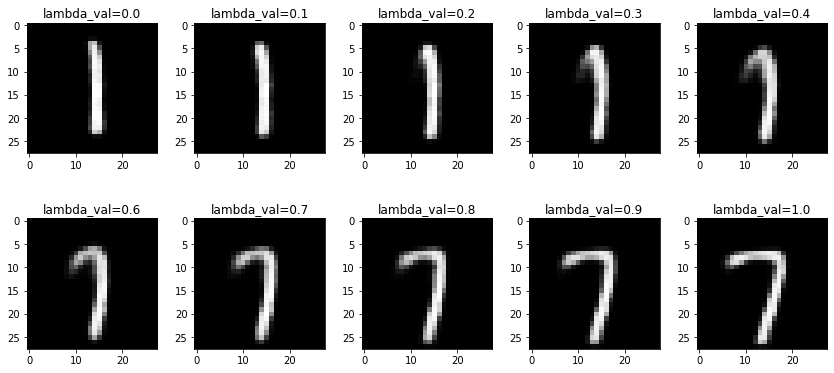

In [ ]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

### **CLASSWORK 1:**

Implement and train a Denoising Autoenoder on the same dataset used above (MNIST). Implement a simple function to add salt and pepper noise ([link](https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/#:~:text=Salt%2Dand%2Dpepper%20noise%20is,%2C%20bit%20transmission%20error%2C%20etc.)) to the images. Plot images for some of the classes before and after denoising.

In [ ]:
# Write code here

### **CLASSWORK 2:**

Repeat **CLASSWORK 1** with a different type of noise. Compare the 3 different types of atoencoders listed below and analyze the differences:

1. Denoising Autoencoder for salt-and-pepper noise.
2. Denoising Autoencoder for the noise chosen in second experiment.
3. Denoising Autoencoder for salt-and-pepper and the noise chosen in second experiment (i.e. both types of noise present in the image).

In [ ]:
# Write code here

### **HOMEWORK:**

Implement Variational Autoencoders (VAEs) and plot the intermediate images when moving from latent space of '5' to that of '1'. 

In [ ]:
# Write code here